In [2]:
#external libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point,Polygon
import matplotlib.pyplot as plt
import folium
from folium.plugins import TimestampedGeoJson
from datetime import datetime

import matplotlib as mpl
import matplotlib.colors as mcolors

%matplotlib inline
%load_ext autoreload

In [3]:
#local imports
from func.DataLoader import gdfLoader,ReadMarkerMap,RSSIDataLoader
from func.utils.getMarkerDictList import getMarkerDictList
from func.FoliumFeatureCreation.RawDataFeatures import RawDataFeatures
from func.utils.TimestampReformat import TimestampReformat

In [4]:
MapDataPath="data/cartePalaiseau.csv"
ModuleMapPath="data/carteModulePalaiseau.csv"
Data_Path="data/manip1.1.csv"

saving_output=False
rolling_mean=10#rolling mean for rssi values in seconds
sampling_time=2000#ms #si supérieur à 2000ms il faut implémenter la moyenne dans la liste des rssi dans marker dict list

### Data loading


In [5]:
#Map Data
map_gdf=gdfLoader(MapDataPath)
map_gdf.to_crs(epsg=4326, inplace=True)
#marker data
marker_gdf=ReadMarkerMap(ModuleMapPath)
#rssi data
raw_rssi_df=RSSIDataLoader(Data_Path)

In [6]:
#to optimize the getting of location of macModule, we create a dictionnary
MacModuleLocation = marker_gdf.set_index("macModule").to_dict()["geometry"]

### Bind the received RSSI Data to the CartoModule Marker on Map

In [7]:
#create a list of timestamps between min_timestamp and max_timestamp with a step of sampling_time
min_timestamp=raw_rssi_df.iloc[0]['timestamp']+pd.Timedelta(sampling_time, unit="ms")
max_timestamp=raw_rssi_df.iloc[-1]['timestamp']
timestamp_list= pd.date_range(start=min_timestamp, end=max_timestamp, freq=str(sampling_time)+"ms").tolist()


In [8]:
MarkerDictList=getMarkerDictList(raw_rssi_df, timestamp_list)

colormap creation

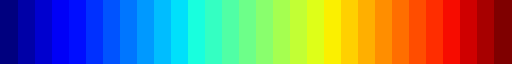

In [9]:
cmap = mpl.colormaps['jet'].resampled(30)
cmap = mpl.colors.ListedColormap(cmap(np.linspace(0, 1, 30)))
cmap

In [10]:
raw_data_features=RawDataFeatures(MarkerDictList,timestamp_list,MacModuleLocation,cmap)
MarkerLayer=TimestampedGeoJson(
                    {"type": "FeatureCollection","features": raw_data_features},
                    period='PT2S',
                    duration='PT1S',
                    transition_time=sampling_time,
                    auto_play=True)

In [11]:
m = folium.Map(location = [48.713166904690254, 2.2007200581389768],max_zoom=30, zoom_start=20,crs="EPSG3857")
folium.TileLayer('stamenterrain').add_to(m)
tooltip = folium.features.GeoJsonTooltip(fields=['ID_element', 'nom'], 
                                        labels=True,
                                        stick=False)
folium.GeoJson(map_gdf, tooltip=tooltip).add_to(m)
MarkerLayer.add_to(m)
folium.LayerControl().add_to(m)
if saving_output:
    m.save('output/marker_map.html')
m

## moving average implementation on the received RSSI data
we need to unify all the received RSSI data in a single dataframe with all the received RSSI data from all the receivers and for each timestamp

timestamp | RSSI for macModule x | RSSI for macModule y | RSSI for macModule z
--- | --- | --- | ---
2023-06-01 12:35:48.605000 | -65 | -70 | None
2023-06-01 12:35:50.605000 | None | -75 | None
2023-06-01 12:35:52.605000 | -61 | -74 | None
2023-06-01 12:35:54.605000 | -50 | -73 | None

In [12]:
MarkerDictList=getMarkerDictList(raw_rssi_df, timestamp_list)


In [13]:
#create the dataframe with the timestamp
rssi_df = pd.DataFrame({'timestamp': pd.to_datetime(timestamp_list)})

#set timestamp as index ?
rssi_df.set_index('timestamp', inplace=True)

#fill the dataframe with NaN
for i in MacModuleLocation.keys():
    rssi_df[i]=np.nan
#fill the dataframe with the rssi value from the MarkerDictList
for i in range(len(MarkerDictList)):
    for key in MarkerDictList[i]:
        rssi_df.loc[timestamp_list[i],key]=MarkerDictList[i][key]
#apply the rolling mean on each column
rssi_df=rssi_df.rolling(str(rolling_mean)+"s").mean()

In [14]:

def getFeatureList(rssi_df,MacModuleLocation):
    input_format = '%Y-%m-%d %H:%M:%S.%f'
    output_format = '%Y-%m-%dT%H:%M:%S'
    pointList=[]
    MarkerTimestamplist=[]
    rssiList=[]
    #iterate through rssidf to fill PointList,MarkerTimestamplist,rssiList
    for index,timestamp in enumerate(rssi_df.index):
        dt = datetime.strptime(str(timestamp), input_format)
        new_timestamp = dt.strftime(output_format)
        for macModule in MacModuleLocation.keys():
            if not np.isnan(rssi_df.iloc[index][macModule]):
                point=MacModuleLocation[macModule]
                pointList.append([point.x,point.y])
                MarkerTimestamplist.append(new_timestamp)
                rssiList.append(rssi_df.iloc[index][macModule])
                
    return pointList,MarkerTimestamplist,rssiList


def CreateFeatures(pointList,rssiList,MarkerTimestamplist,cmap):
    features = []
    for index in range(len(pointList)):
        rgb_list=cmap(int(rssiList[index]+80))
        print(rssiList[index])
        hex_color=mcolors.rgb2hex(rgb_list)
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': pointList[index]
            },
            'properties': {
                'times': [MarkerTimestamplist[index]],
                "icon": 'circle',
                "popup": str(rssiList[index]),
                "iconstyle": {
                    "color": hex_color,
                    "fillColor": hex_color,    
                    "fillOpacity": "0.8",  
                    "radius": str(int(1*(80+rssiList[index])))  #radius must be an integer    
                }}
            }
        features.append(feature)
    return features


In [15]:
pointList,MarkerTimestamplist,rssiList=getFeatureList(rssi_df,MacModuleLocation) 
rolled_data_features=CreateFeatures(pointList,rssiList,MarkerTimestamplist,cmap)

-78.0
-78.0
-67.0
-70.0
-66.0
-71.0
-78.0
-78.0
-67.0
-70.0
-66.0
-71.0
-77.5
-78.0
-66.5
-70.0
-66.0
-75.5
-77.5
-78.0
-66.5
-73.0
-66.0
-75.5
-78.0
-77.5
-77.0
-67.33333333333333
-71.5
-66.0
-74.66666666666667
-75.5
-77.0
-76.0
-67.5
-72.0
-66.0
-76.5
-74.33333333333333
-77.0
-76.0
-68.0
-72.0
-66.0
-74.33333333333333
-74.33333333333333
-70.0
-74.0
-67.66666666666667
-70.33333333333333
-66.0
-72.33333333333333
-73.75
-71.0
-74.33333333333333
-67.66666666666667
-70.0
-72.0
-72.33333333333333
-72.33333333333333
-71.0
-73.5
-63.666666666666664
-71.5
-74.33333333333333
-70.66666666666667
-70.66666666666667
-71.0
-73.5
-63.666666666666664
-73.0
-78.66666666666667
-70.66666666666667
-70.0
-73.66666666666667
-73.5
-63.0
-73.0
-78.66666666666667
-68.33333333333333
-70.0
-73.0
-79.0
-75.5
-62.0
-77.0
-78.66666666666667
-65.5
-68.0
-73.5
-77.0
-79.0
-76.0
-67.0
-76.5
-79.0
-66.66666666666667
-68.0
-70.33333333333333
-77.0
-78.5
-73.0
-71.0
-71.0
-76.5
-79.0
-64.33333333333333
-67.0
-68.0
-78.5

In [16]:
MarkerLayer=TimestampedGeoJson(
                    {"type": "FeatureCollection","features": rolled_data_features},
                    period='PT2S',
                    duration='PT1S',
                    transition_time=sampling_time,
                    auto_play=True)

In [17]:
m = folium.Map(location = [48.713166904690254, 2.2007200581389768],max_zoom=30, zoom_start=20,crs="EPSG3857")
tooltip = folium.features.GeoJsonTooltip(fields=['ID_element', 'nom'], 
                                        labels=True,
                                        stick=False)
folium.GeoJson(map_gdf, tooltip=tooltip).add_to(m)
MarkerLayer.add_to(m)
folium.LayerControl().add_to(m)
if saving_output:
    m.save('output/rolled_marker_map.html')
m

In [18]:
rssi_df.head()

,A8032A31204E,C45BBE39F42A,C45BBE39F9AE,A8032A311FAA,C45BBE39F56A,C45BBE37B346,C45BBE386952,C45BBE386362,C45BBE384CD2,C45BBE39870E,...,A8032A311FBA,A8032A311F52,A8032A311DBA,A8032A30FBEE,A8032A311DD2,A8032A30FBDE,A8032A30FBE2,A8032A30FBA2,A8032A311F8A,C45BBE3820DA
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-06-01 12:35:48.605,NaN,NaN,NaN,-78.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-01 12:35:50.605,NaN,NaN,NaN,-78.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-01 12:35:52.605,NaN,NaN,NaN,-77.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-01 12:35:54.605,NaN,NaN,NaN,-77.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-06-01 12:35:56.605,-78.0,NaN,NaN,-77.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
#weighted centroid implementation 
g=0.02#degree of weight
def getWeightedCentroid(rssi_df,MacModuleLocation):
    CentroidList=[]
    timestamp_list=[]
    #iterate through rssidf to fill PointList,MarkerTimestamplist,rssiList
    for index,timestamp in enumerate(rssi_df.index):
        
        pointList=[]#list of tuple ((x,y),rssi)
        for macModule in MacModuleLocation.keys():
            if not np.isnan(rssi_df.iloc[index][macModule]):
                point=MacModuleLocation[macModule]
                pointList.append(([point.x,point.y],rssi_df.iloc[index][macModule]))
        #weighted centroid algorithm lack of a precision defining variable
        if len(pointList)>0:            
            x=0
            y=0
            sumrssi=0
            for point,rssi in pointList:
                x=x+point[0]*((2**rssi)**g)
                y=y+point[1]*((2**rssi)**g)
                sumrssi=sumrssi+((2**rssi)**g)
            x=x/sumrssi
            y=y/sumrssi
            CentroidList.append([x,y])
            timestamp_list.append(TimestampReformat(timestamp))
    return CentroidList,timestamp_list
CentroidList,timestamp_list=getWeightedCentroid(rssi_df,MacModuleLocation)


In [24]:
def CreateFeaturesMarker(CentroidList,timestamp_list):
    features = []
    for index in range(len(CentroidList)):
        feature = {
            'type': 'Feature',
            'geometry': {
                'type': 'Point',
                'coordinates': CentroidList[index]
            },
            'properties': {
                'times': [timestamp_list[index]],
                "icon": 'circle',
                "popup": str(rssiList[index]),
                "iconstyle": {
                    "color": "black",
                    "fillOpacity": "0.8",  
                    "radius":'5'
                }}
            }
        features.append(feature)
    return features


In [25]:
features=CreateFeaturesMarker(CentroidList,timestamp_list)
MarkerLayer=TimestampedGeoJson(
                    {"type": "FeatureCollection","features": features},
                    period='PT2S',
                    duration='PT1S',
                    transition_time=sampling_time,
                    auto_play=True)

In [26]:
m = folium.Map(location = [48.713166904690254, 2.2007200581389768],max_zoom=30, zoom_start=20,crs="EPSG3857")
tooltip = folium.features.GeoJsonTooltip(fields=['ID_element', 'nom'], 
                                        labels=True,
                                        stick=False)
folium.GeoJson(map_gdf, tooltip=tooltip).add_to(m)
MarkerLayer.add_to(m)
folium.LayerControl().add_to(m)
if saving_output:
    m.save('output/rolled_marker_map.html')
m